### Monte Carlo Tweezer Ramp

In [1]:
using BeamPropagation, 
    Distributions, 
    UnitsToValue,
    StatsBase, 
    StaticArrays, 
    Plots,
    StructArrays,
    MutableNamedTuples,
    PhysicalConstants.CODATA2018,
    LinearAlgebra

In [138]:
# Define physical constants
const kB = BoltzmannConstant.val
const T = @with_unit 180 "μK"

# Define molecule parameters for CaOH
const m = @with_unit 57 "u"
const v_recoil = @with_unit 1.1 "cm/s"
;

In [139]:
# Define tweezer beam properties
const T_depth = @with_unit 1.4 "mK"
const U_max = kB * T_depth
const λ = 780e-9
const w0x = 2.0e-6
const w0y = 2.0e-6

# Create an instance of a gaussian trap for the tweezer
trap = AsymmetricGaussianTrap(λ=λ, w0x=w0x, w0y=w0y, U_max=U_max, m=m)
;

In [140]:
total_time = @with_unit 100 "ms"          
ramp_down_start = @with_unit 10 "ms"       
ramp_up_start = @with_unit 50 "ms"         
ramping_time = @with_unit 10 "ms"
ramped_U_depth = (0.5 / 4) * U_max
;

In [141]:
function ramp(p, time)
    U = 0.0
    if p.ramp_down_start <= time < (p.ramp_down_start + p.ramping_time)
        U += (p.trap.U_max * (p.ramp_down_start + p.ramping_time - time) / p.ramping_time
            + p.ramped_U_depth * (time - p.ramp_down_start) / p.ramping_time)
    elseif (p.ramp_down_start + p.ramping_time) <= time < p.ramp_up_start
        U += p.ramped_U_depth
    elseif p.ramp_up_start <= time < (p.ramp_up_start + p.ramping_time)
        U += (p.ramped_U_depth * (p.ramp_up_start + p.ramping_time - time) / p.ramping_time
            + p.trap.U_max * (time - ramp_up_start) / p.ramping_time)
    else
        U += p.trap.U_max
    end
    return U
end;

In [142]:
n = 100
save_every = 100
delete_every = 50
dt_min = 1e-10
dt_max = 1e-4
abstol = 1e-5
dt = 1e-7
max_steps = Int64(ceil(total_time / dt))
alg = "rkf12"
use_adaptive = false
dt0 = 1e-5
times = (0:dt:max_steps * dt)[1:save_every:end-1]
;

In [143]:
discard(r, v) = false
is_detectable(r, trap) = (abs(r[1]) < 5trap.w0x) && (abs(r[2]) < 5trap.w0y) && (abs(r[3]) < 5max(trap.zRx, trap.zRy))

function update(particles, p, s, dt, time, idx)
    for i in 1:size(particles, 1)
        idx = particles.idx[i]
        r = particles.r[i]
        s.detectable[idx] = is_detectable(r, p.trap)
    end
    return nothing
end

gravity(r) = SVector(0.0, -9.81, 0.0)

function f(idx, r, v, p, time)
    U_depth = ramp(p, time)
    return F(r, p.trap) * U_depth / m + gravity(r)
end

function save(particles, p, s)
    for i in 1:size(particles, 1)
        idx = particles.idx[i]
        push!(s.trajectories[idx], particles.r[i])
    end
    return nothing
end
;

In [144]:
detectable = zeros(Bool, n)

particles = StructArray{Particle}(undef, n)
trajectories = [SVector{3, Float64}[] for _ ∈ 1:length(particles)]

r, v, a = make_distributions(T, trap)

p = @params (trap, ramp_down_start, ramp_up_start, ramping_time, ramped_U_depth)
s = @params (detectable, trajectories)

@time propagate_particles!(r, v, a, 
    alg, particles, f, save, discard, save_every, delete_every, max_steps, update, p, s, dt, use_adaptive, 
    dt_min, dt_max, abstol, true
)
mean(s.detectable) |> display

 13.996545 seconds (1.16 G allocations: 29.309 GiB, 29.62% gc time, 15.79% compilation time: 8% of which was recompilation)


0.86

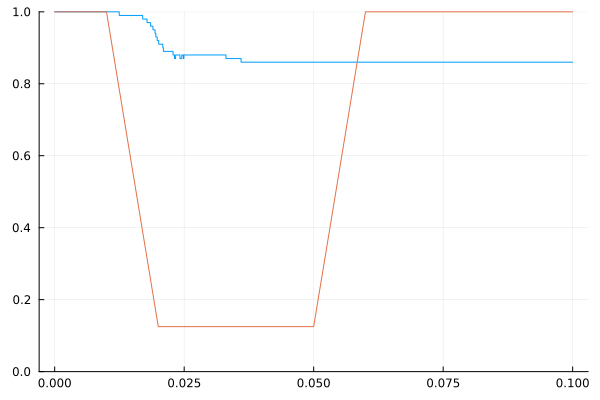

In [145]:
survival = vec(mean(mapreduce(permutedims, vcat, [[is_detectable(s.trajectories[i][j], trap) for j ∈ 1:length(times)] for i ∈ 1:n]), dims=1))
plot(times, survival, legend=nothing)
plot!(ylim=(0,1))
plot!(times, [ramp(p, t) for t ∈ times] ./ p.trap.U_max)
# vline!([release_start_time, release_end_time])

## Scan in-trap temperature to fit to data

In [229]:
# Temperature without ramp
data_xs_ = 1e-6 .* [
    0
    2
    5
    10
    15
    20
    25
    30
    40
]
data_ys_ = [
    0.5556
    0.5862
    0.4516
    0.2752
    0.2184
    0.1895
    0.0678
    0.1019
    0.0682
]
data_ys_ = data_ys_ ./ maximum(data_ys_)

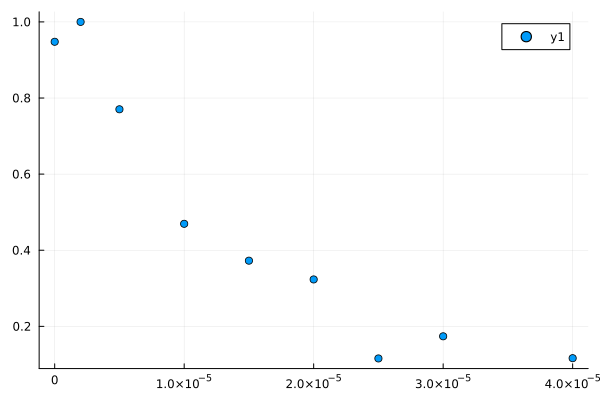

In [230]:
scatter(data_xs_, data_ys_)

In [225]:
data_xs = [
         0
    0.0257
    0.0400
    0.0514
    0.0829
    0.1286
    0.1603
    0.1629
    0.2400
    0.3029
    0.3714
    0.8914
    1.0000
]
data_ys_ = [
   -0.0190
    0.1528
    0.1447
    0.2771
    0.2643
    0.3146
    0.4111
    0.4591
    0.4281
    0.4486
    0.5578
    0.5365
    0.4823
]
data_ys = data_ys_ ./ maximum(data_ys_)
;

In [234]:
const T = @with_unit 190 "μK";

In [235]:
# Create a release-recapture plot for a single temperature
r, v, a = make_distributions(T, trap)
release_durations = deepcopy(data_xs_)

surviving_fractions = zeros(length(release_durations))
for (i, release_duration) ∈ enumerate(release_durations)

    # Reset parameters for current run
    p.release_start_time = release_start_time
    p.release_end_time = release_start_time + release_duration
    
    particles = StructArray{Particle}(undef, n)
    detectable = zeros(Bool, n)
    trajectories = [SVector{3, Float64}[] for _ ∈ 1:length(particles)]
    s = @params (detectable, trajectories)

    @time propagate_particles!(r, v, a, alg, particles, f, save, discard, save_every, delete_every, max_steps, update, p, s, dt, use_adaptive, 
        dt_min, dt_max, abstol, true)

    surviving_fractions[i] = mean(s.detectable)    
end

  0.849999 seconds (2.26 k allocations: 47.224 MiB)
  0.829758 seconds (2.38 k allocations: 47.234 MiB)
  0.861321 seconds (2.39 k allocations: 47.234 MiB)
  0.876953 seconds (2.51 k allocations: 47.244 MiB)
  0.825288 seconds (2.39 k allocations: 47.234 MiB)
  0.924105 seconds (2.51 k allocations: 47.244 MiB)
  0.862219 seconds (2.51 k allocations: 47.244 MiB)
  0.842299 seconds (2.39 k allocations: 47.234 MiB)
  0.829823 seconds (2.39 k allocations: 47.234 MiB)


Error: 0.0056326686295764625

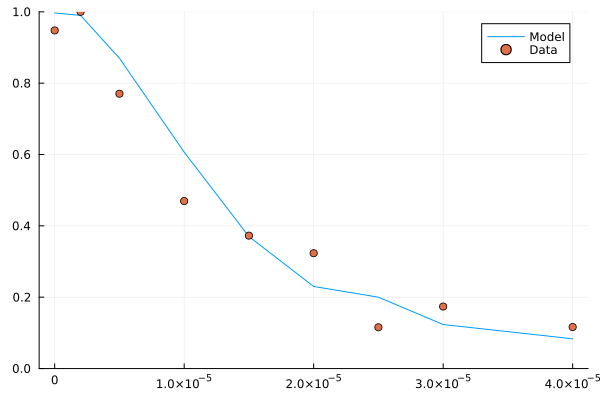

In [236]:
plot(ylim=(0,1))
print("Error: ", mean((surviving_fractions .- data_ys_).^2))
plot!(data_xs_, surviving_fractions, label="Model")
scatter!(data_xs_, data_ys_, label="Data")

In [15]:
center_T = 34.0
Ts = 1e-6 .* collect((center_T-15):1:(center_T+15))
;

surviving_fractions = zeros(length(Ts), length(shaved_U_depth_ratios))

iter = Ts
for (i, T) ∈ enumerate(Ts)
    display(T)

    r, v, a = make_distributions(T, trap)

    for (j, shaved_U_depth_ratio) ∈ enumerate(shaved_U_depth_ratios)
        shaved_U_depth = original_U_depth * shaved_U_depth_ratio

        # Reset parameters for current run
        p.time_ = 0.0
        p.shaved_U_depth = shaved_U_depth

        particles = StructArray{Particle}(undef, n)
        detectable = zeros(Bool, n)
        trajectories = [SVector{3, Float64}[] for _ ∈ 1:length(particles)]
        s = @params (detectable, trajectories)

        @time propagate_particles!(r, v, a, alg, particles, f, save, discard, save_every, delete_every, max_steps, update, p, s, dt, use_adaptive, 
            dt_min, dt_max, abstol, true)

        surviving_fractions[i,j] = mean(s.detectable)    
    end

end

LoadError: UndefVarError: `shaved_U_depth_ratios` not defined

In [16]:
χ²(data, data_errors, preds) = sum((data .- preds).^2 ./ data_errors.^2);

In [17]:
function model_with_best_scaling(model_ys, data_ys, data_ys_errors)
    min_error = Inf
    best_scaling = 1.0
    for scaling ∈ 0.1:0.01:0.4
        error = χ²(data_ys, data_ys_errors, model_ys .* scaling)
        if error < min_error
            min_error = error
            best_scaling = scaling
        end
    end
    print(best_scaling)
    return model_ys .* best_scaling
end

model_with_best_scaling (generic function with 1 method)

In [18]:
χ²_errors = 1e-12 .* [
    χ²(
        data_ys, 
        data_ys_errors, 
        model_with_best_scaling(surviving_fractions[i,:], data_ys, data_ys_errors)
        ) 
    for i ∈ 1:size(surviving_fractions, 1)]
;

LoadError: UndefVarError: `data_ys_errors` not defined

In [19]:
using LsqFit
@. model(T, p) = p[1] * (T - p[2])^2 + p[3]

LoadError: ArgumentError: Package LsqFit not found in current path.
- Run `import Pkg; Pkg.add("LsqFit")` to install the LsqFit package.

In [20]:
x = 0
y = 0
lb = [0, 10.0, 10]
p0 = [1e2, 31.0, 32]
ub = [1e4, 70.0, 50]
fitted_model = curve_fit(model, Ts[x+1:end-y] .* 1e6, χ²_errors[x+1:end-y] .* 1e12, p0, lower=lb, upper=ub)
display(fitted_model.param)
plot(Ts[x+1:end-y] .* 1e6, χ²_errors[x+1:end-y]  .* 1e12, label="χ² errors")
plot!(Ts[x+1:end-y] .* 1e6, model(Ts[x+1:end-y] .* 1e6, fitted_model.param), label="Parabola")

LoadError: UndefVarError: `χ²_errors` not defined

In [21]:
# The second derivative with respect to T is given by
sqrt(2 * (2 * fitted_model.param[1])^(-1))

LoadError: UndefVarError: `fitted_model` not defined

In [22]:
min_error, best_idx = findmin(χ²_errors)
Ts[best_idx] |> display
best_preds = model_with_best_scaling(surviving_fractions[best_idx,:], data_ys, data_ys_errors)

plot(shaved_U_depth_ratios .* 3.5, best_preds, legend=nothing, size=(700,400))
scatter!(data_xs, data_ys)

LoadError: UndefVarError: `χ²_errors` not defined

In [23]:
shaved_U_depth_ratios

LoadError: UndefVarError: `shaved_U_depth_ratios` not defined

### Bootstrap model outputs to get an error range

In [24]:
collect(shaved_U_depth_ratios[1]:0.01:shaved_U_depth_ratios[end])

LoadError: UndefVarError: `shaved_U_depth_ratios` not defined

In [25]:
n = 2_000
T = 60e-6
r, v, a = make_distributions(T)

simul_xs = collect(shaved_U_depth_ratios[1]:0.01:shaved_U_depth_ratios[end])

detectable_all = zeros(n, length(simul_xs))

for (j, shaved_U_depth_ratio) ∈ enumerate(simul_xs)
    shaved_U_depth = original_U_depth * shaved_U_depth_ratio

    # Reset parameters for current run
    p.time = 0.0
    p.shaved_U_depth = shaved_U_depth

    particles = StructArray{Particle}(undef, n)
    detectable = zeros(Bool, n)
    trajectories = [SVector{3, Float64}[] for _ ∈ 1:length(particles)]
    s = @params (detectable, trajectories)

    @time propagate_particles!(r, v, a, alg, particles, f, save, discard, save_every, delete_every, max_steps, update, p, s, dt, use_adaptive, 
        dt_min, dt_max, abstol, true)

    detectable_all[:,j] .= s.detectable
    
end

LoadError: MethodError: no method matching make_distributions(::Float64)

[0mClosest candidates are:
[0m  make_distributions(::Any, [91m::AsymmetricGaussianTrap[39m)
[0m[90m   @[39m [35mBeamPropagation[39m [90mC:\Google Drive\github\BeamPropagation\src\[39m[90m[4mAsymmetricGaussianTrap.jl:54[24m[39m


In [26]:
n_bootstraps = 10000

surviving_fractions_lower = zeros(length(simul_xs))
surviving_fractions_upper = zeros(length(simul_xs))

for i ∈ eachindex(simul_xs)
    bootstrap_idxs = rand(1:n, n, n_bootstraps)
    bootstrap_samples = detectable_all[:,i][bootstrap_idxs]
    bootstrap_means = vec(mean(bootstrap_samples, dims=1))
    surviving_fractions_lower[i] = percentile(bootstrap_means, 50 - 34.1)
    surviving_fractions_upper[i] = percentile(bootstrap_means, 50 + 34.1)
end

LoadError: UndefVarError: `simul_xs` not defined

In [27]:
plot(simul_xs, surviving_fractions_lower, fillrange=surviving_fractions_upper, legend=nothing)

LoadError: UndefVarError: `surviving_fractions_upper` not defined

In [28]:
simul_vals = vec(mean(detectable_all, dims=1));

LoadError: UndefVarError: `detectable_all` not defined

In [29]:
simul_vals

LoadError: UndefVarError: `simul_vals` not defined

### Bootstrapping data

In [30]:
using Distributions

In [31]:
data_sampler(μs, ϵs) = [Normal(μs[i], ϵs[i]) for i ∈ eachindex(μs)]
ds = data_sampler(data_ys, data_ys_errors)
;

LoadError: UndefVarError: `data_ys_errors` not defined

In [32]:
n_bootstraps = 100_000
min_Ts = zeros(n_bootstraps)

for i ∈ 1:n_bootstraps
    bootstrap_sample = rand.(ds)
    squared_errors = vec(sum((bootstrap_sample .- surviving_fractions').^2 ./ length(data_ys), dims=1))
    _, best_idx = findmin(squared_errors)
    min_Ts[i] = Ts[best_idx]
end
histogram(min_Ts, bins=Ts)

LoadError: UndefVarError: `ds` not defined

In [33]:
mean(min_Ts)

0.0

In [34]:
percentile(min_Ts, 50 - 34.1) |> display
percentile(min_Ts, 50 + 34.1) |> display

0.0

0.0